In [ ]:
#struggled to work

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import h5py

In [3]:
hf = h5py.File('real-attpc-events.h5', 'r')

In [4]:
list(hf.keys())

['features', 'targets']

In [5]:
hf['features'].shape

(2689, 128, 128)

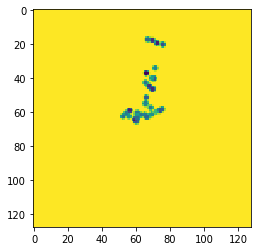

In [6]:
plt.imshow(hf['features'][0])

In [7]:
print(hf['targets'][2005])

2


In [8]:
data = hf['features']
label = hf['targets']

In [9]:
train_data = data[0:1800]
test_data = data[1800:2689]
train_label = label[0:1800]
test_label = label[1800:2689]

In [10]:
image_width, image_length = 128, 128
image_shape = (128,128)

#Reshape data (https://www.machinecurve.com/index.php/2020/04/13/how-to-use-h5py-and-keras-to-train-with-data-from-hdf5-files/)

train_data = train_data.reshape((len(train_data), image_width, image_length))
test_data = test_data.reshape((len(test_data), image_width, image_length))

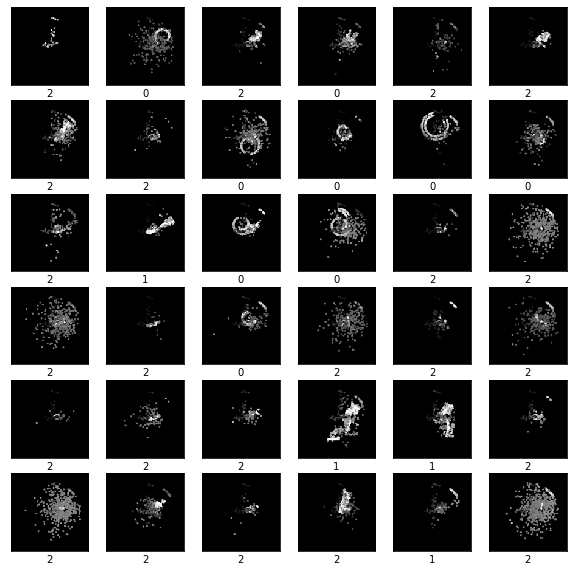

In [11]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(label[i])
plt.show()

In [12]:
#Normalize datasets
train = train_data/255.0
test = test_data/255.0

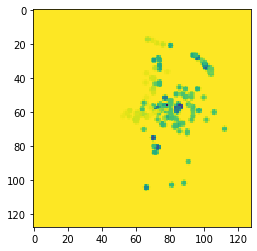

In [13]:
train_data[4]
plt.imshow(train_data[4])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [15]:
FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Flatten(input_shape=(128,128)))
FCNN_model.add(layers.Dense(250, activation='relu'))
FCNN_model.add(layers.Dropout(0.5))
#FCNN_model.add(layers.Dense(250, activation='relu'))
#FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(layers.Dense(3, activation = 'softmax'))

In [16]:
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [17]:
FCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               4096250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 753       
Total params: 4,097,003
Trainable params: 4,097,003
Non-trainable params: 0
_________________________________________________________________


In [18]:
FCNN_history = FCNN_model.fit(train_data, train_label,
                             epochs=60,
                             batch_size = 32,
                             shuffle = True,
                             callbacks = [callback],
                             validation_split = 0.3
                             )

Epoch 1/60
40/40 [==============================] - 1s 31ms/step - loss: 10672.9727 - accuracy: 0.4516 - val_loss: 9.9869 - val_accuracy: 0.2519
Epoch 2/60
40/40 [==============================] - 1s 26ms/step - loss: 50.0681 - accuracy: 0.6048 - val_loss: 1.0235 - val_accuracy: 0.6259
Epoch 3/60
40/40 [==============================] - 1s 26ms/step - loss: 97.3480 - accuracy: 0.6159 - val_loss: 0.9704 - val_accuracy: 0.6259
Epoch 4/60
40/40 [==============================] - 1s 26ms/step - loss: 0.9595 - accuracy: 0.6206 - val_loss: 0.9367 - val_accuracy: 0.6278
Epoch 5/60
40/40 [==============================] - 1s 26ms/step - loss: 0.9364 - accuracy: 0.6206 - val_loss: 0.9184 - val_accuracy: 0.6278
Epoch 6/60
40/40 [==============================] - 1s 26ms/step - loss: 124.7813 - accuracy: 0.6063 - val_loss: 0.9082 - val_accuracy: 0.6278
Epoch 7/60
40/40 [==============================] - 1s 26ms/step - loss: 0.9168 - accuracy: 0.6206 - val_loss: 0.9009 - val_accuracy: 0.6278
Epoch

In [19]:
result = FCNN_model.evaluate(test, test_label, verbose=2)

28/28 - 0s - loss: 0.8879 - accuracy: 0.6344


In [20]:
predictions = np.argmax(FCNN_model.predict(test_data[:]),axis=1)

In [21]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       220
           1       0.00      0.00      0.00       105
           2       0.63      1.00      0.78       564

    accuracy                           0.63       889
   macro avg       0.21      0.33      0.26       889
weighted avg       0.40      0.63      0.49       889



/opt/anaconda3/envs/REU/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


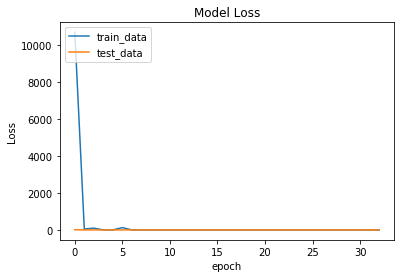

In [22]:
plt.plot(FCNN_history.history['loss'])
plt.plot(FCNN_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train_data', 'test_data'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

In [24]:
cm = confusion_matrix(test_label, predictions)

In [25]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         include_values=True,
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

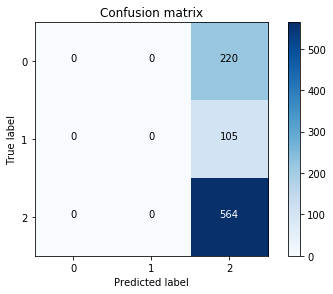

In [26]:
cm_plot_labels = ['0', '1', '2']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')